### Imports

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
#Function import
from model import UNet_baysian
from utils import make_one_hot, generate_target, generate_target_swap
from attack import DAG
from random import randint

### Hyperparamters for the attack

In [2]:
num_iterations=20
gamma=0.5
num=15

### Loading model and inputs

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_all, label_all=np.load('datasets/OASIS/img.npy'), np.load('datasets/OASIS/lbl.npy')
model=UNet_baysian()
model.load('./checkpoints/unet_baysian.pkl')
model=model.to(device)

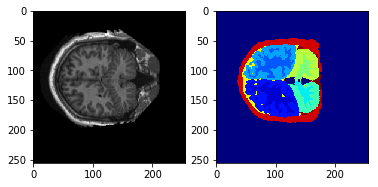

In [4]:
idx=randint(0,len(image_all)-1)
image,label=image_all[idx],label_all[idx]
plt.figure()
plt.subplot(121)
plt.imshow(image[0][0],cmap='gray')
plt.subplot(122)
plt.imshow(label[0],cmap='jet')
plt.show()

In [5]:
image , label = torch.tensor(image, requires_grad=True).float(), torch.tensor(label).float()
image , label = image.to(device), label.to(device)

### Attacking the model

#### Generating Target
There are two type of targets available:
-  __generate_target__ increases the thickness of the skull
-  __generate_target_swap__ swaps the most common classes

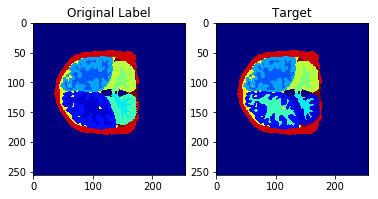

In [6]:
# Change labels from [batch_size, height, width] to [batch_size, num_classes, height, width]
label_oh=make_one_hot(label.long(),15,device)
adv_target=generate_target_swap(label_oh.cpu().numpy())
adv_target=torch.from_numpy(adv_target).float()
adv_target=adv_target.to(device)

#Visualizing the target
_, adv=torch.max(adv_target,1)
adv=adv[0].cpu().numpy()
plt.figure()
plt.subplot(121)
plt.title('Original Label')
plt.imshow(label[0].cpu().numpy(),cmap='jet')
plt.subplot(122)
plt.title('Target')
plt.imshow(adv,cmap='jet')
plt.show()

In [7]:
image_adv,output_clean, noise_total, noise_iteration, prediction_iteration, image_iteration=DAG(model=model,
              image=image,
              ground_truth=label_oh,
              adv_target=adv_target,
              num_iterations=num_iterations,
              gamma=gamma,
              no_background=True,
              background_class=0,
              device=device,
              verbose=False)

/home/ferjad/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/ferjad/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Condition Reached, no gradient


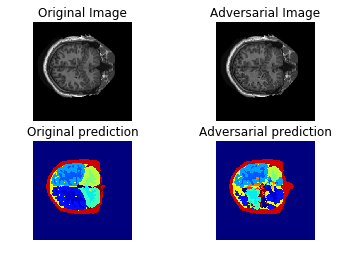

In [8]:
plt.figure()
plt.subplot(221)
plt.title('Original Image')
plt.imshow(image_iteration[0],cmap='gray')
plt.axis('off')
plt.subplot(222)
plt.title('Adversarial Image')
plt.imshow(image_iteration[-1],cmap='gray')
plt.axis('off')
plt.subplot(223)
plt.title('Original prediction')
plt.imshow(prediction_iteration[0],cmap='jet')
plt.axis('off')
plt.subplot(224)
plt.title('Adversarial prediction')
plt.imshow(prediction_iteration[-1],cmap='jet')
plt.axis('off')
plt.show()